## CFFI, Ctypes, Cython: The good, the bad and the ugly

## Pycon Israel 2017

## Matti Picus

### You can follow along at https://github.com/mattip/pycon2017_cffi/blob/master/pycon2017_cffi.ipynb

![The movie poster](https://images-na.ssl-images-amazon.com/images/M/MV5BMTQxNDcyMjE4NF5BMl5BanBnXkFtZTgwNTU4ODE5MDE@._V1_.jpg)

### Thanks for coming, I too would rather be in the lecture about Grumpy and PyPy next door

Here is what we will do

<p></p>
<details>
<summary>The ``mandel`` image (5 minutes)</summary>  
  
  - Pure python  
  - Pure C  
  - Timing it
</details>  
<p></p>
<details>
<summary>How to mix C and Python (10-15 minutes)</summary>  
  - Ctypes  
  - CFFI
  - Cython
</details>  
<p></p>
<details>
<summary>Comparison - which is the good, the bad, and the ugly (5-10 minutes)</summary>  
  - Boilerplate  
  - Maintenance  
  - Speed
</details>
<p></p>
A pop quiz
<p></p>
Questions

In [1]:
from __future__ import print_function, division
%matplotlib notebook
from timeit import default_timer as timer
import numpy as np
from PIL import Image
from matplotlib.pylab import imshow, show, figure, subplots

Our mission: to create a fractal image. Hmm, what is an image? We decide to define a simple structure to hold the image: width, height, data-as-pointer

In [2]:
class Img(object):
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.data = bytearray(width*height)

width = 1500
height = 1000
image = Img(width, height)

Now we design an API where we loop over the image, doing a calculation at each pixel location.
For reasons known to only a select few, we normalize the horizontal values to be from -2 to 1 and the vertical values to -1 to 1, and then call a function with these normalized values. Also, our system architect is adamant that every function return a status, so our calculation function must accept a pointer to the value to be returned. This makes more sense in C, but can be done in python as well, although awkwardly.

We use ``oneval`` as an object that can be passed in as a "pointer"

### The looping function

these links are so we can jump forward when we come back to look again at this function  
[as used in ctypes](#Ctypes-use)  
[as used in CFFI](#CFFI-use)  
[as used in Cython](#Cython-use)  


In [3]:
def create_fractal(image, iters, func, oneval):
    ''' Call a function for each pixel in the image, where
        -2 < real < 1 over the columns and
        -1 < imag < 1 over the rows
    '''
    pixel_size_x = 3.0 / image.width
    pixel_size_y = 2.0 / image.height
    for y in range(image.height):
        imag = y * pixel_size_y - 1
        yy = y * image.width
        for x in range(image.width):
            real = x * pixel_size_x - 2
            
            ret = func(real, imag, iters, oneval) # <---- HERE is the real work
            if ret < 0:
                return ret
            image.data[yy + x] = oneval[0]
    return 0

In [4]:
# This is the calculating function in python

def mandel(x, y, max_iters, value):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            value[0] = i
            return 0
    value[0] = max_iters
    return max_iters

In [5]:
# OK, lets try it out. Here is our pure python fractal generator

oneval = bytearray(1)
s = timer()
ret = create_fractal(image, 20, mandel, oneval)
e = timer()
if ret < 0:
    print('bad ret value from creat_fractal')
pure_python = e - s
print('pure python required {:.2f} secs'.format(pure_python))
im = Image.frombuffer("L", (width, height), image.data, "raw", "L", 0, 1)
im.save('python_numpy.png')

pure python required 5.23 secs


<IPython.core.display.Javascript object>


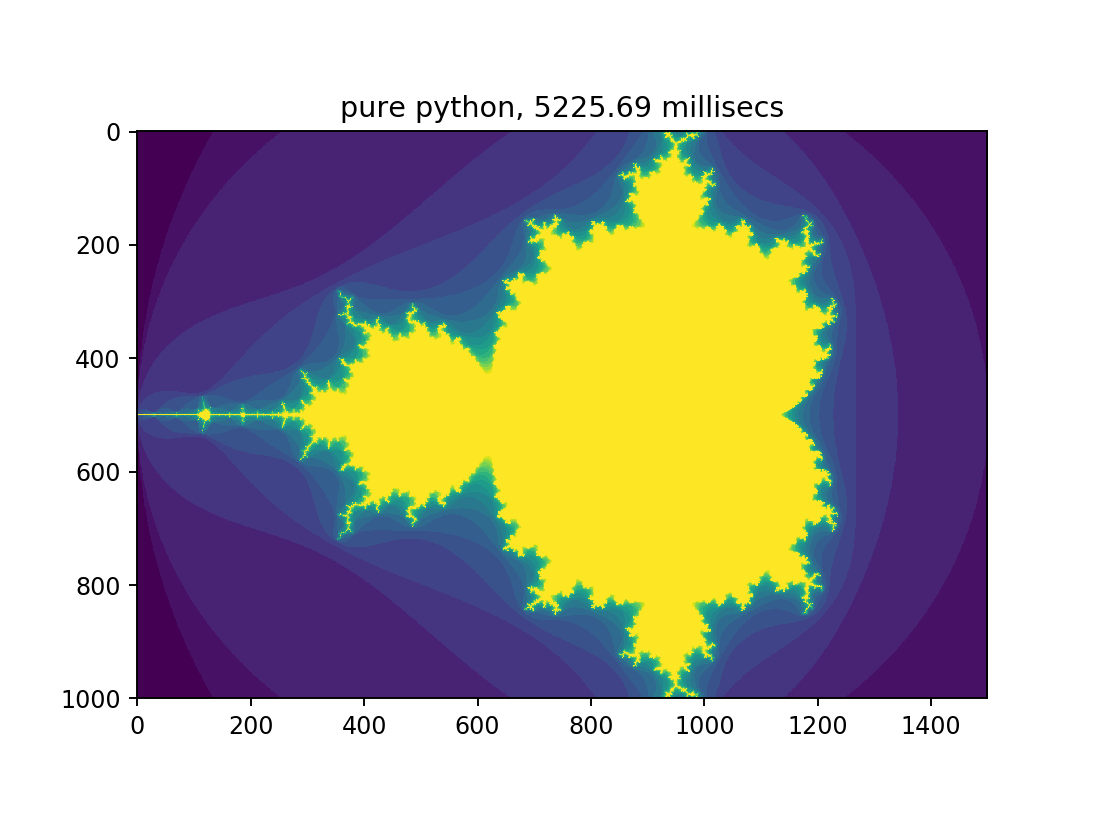

In [11]:
fig, ax = subplots(1)
img = Image.open('python_numpy.png')
ax.imshow(img); 
ax.set_title('pure python, {:.2f} millisecs'.format(pure_python*1000));

EVERYONE KNOWS PYTHON IS TOO SLOW! So we outsource the whole thing to a 
contractor, keeping the format of two functions and their signatures. 
The contractor rewrites it in C, now the ``*val`` make sense

In [7]:
with open('mandel.c', 'rt') as fid:
    print(fid.read())

#include <complex.h>

int mandel(float x, float y, int max_iters, unsigned char * val)
{
    int i = 0;
    _Complex float c = CMPLX(x, y);
    _Complex float z = CMPLX(0, 0);
    for (i = 0; i < max_iters; i++)
    {
        z = z * z + c;
        if ((crealf(z) * crealf(z) + cimagf(z) * cimagf(z)) >= 4)
        {
            *val = i;
            return 0;
        }
    }
    *val = max_iters;
    return 1;
}



In [8]:
with open('create_fractal.c', 'rt') as fid:
    print(fid.read())

int mandel(float x, float y, int max_iters, unsigned char * val);

typedef struct _Img{
    int width;
    int height;
    unsigned char * data;
} Img;


void create_fractal(Img img,  int iters) {
    float pixel_size_x = 3.0 / img.width;
    float pixel_size_y = 2.0 / img.height;
    for (int y=0; y < img.height; y++) {
        float imag = y * pixel_size_y - 1;
        int yy = y * img.width;
        for (int x=0; x < img.width; x++) {
            float real = x * pixel_size_x - 2;
            unsigned char color;
            int ret = mandel(real, imag, iters, &color);
            img.data[yy + x] = color;
        }
    }
}



In [9]:
%%bash
# The contractor provided a demo. We will compile the functions into a shared object
# and time the call to create_fractal, as before
cat main.c

# Compile a shared object, and then compile the exe
gcc --shared -fPIC -O3 mandel.c create_fractal.c -o libcreate_fractal.so
gcc -O3 main.c -lnetpbm -L. -lcreate_fractal -o main

#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include "create_fractal.h"

// call this function to start a nanosecond-resolution timer
struct timespec timer_start(){
    struct timespec start_time;
    clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &start_time);
    return start_time;
}

// call this function to end a timer, returning nanoseconds elapsed as a long
long timer_end(struct timespec start_time){
    struct timespec end_time;
    clock_gettime(CLOCK_PROCESS_CPUTIME_ID, &end_time);
    long diffInNanos = end_time.tv_nsec - start_time.tv_nsec;
    return diffInNanos;
}


int main(int argc, const char *argv[], const char * env[])
{
    int width = 1500;
    int height = 1000;
    int iters = 20;
    FILE * fid = NULL;
    cImg img;
    struct timespec vartime;
    long time_elapsed_nanos;
    img.width = width;
    img.height = height;
    size_t written;
    img.data = (unsigned char*)malloc(width * height * sizeof(unsigned char));
    if (NULL == img.data)
        return

In [14]:
import subprocess
import os
environ = os.environ.copy()
environ['LD_LIBRARY_PATH'] = environ.get('LD_LIBRARY_PATH', '') + ':'
p = subprocess.Popen(['./main'], stdout=subprocess.PIPE, stderr=subprocess.PIPE, env=environ)
stdout, stderr = p.communicate()
stdout = str(stdout)
print(stdout)
pure_c = int(stdout.split(' ')[2])
print('Pure python is {:.1f} times slower than pure C'.format(1000.0*pure_python/pure_c));

b'create_fractal required 201 millisecs\n'
Pure python is 26.0 times slower than pure C


<IPython.core.display.Javascript object>


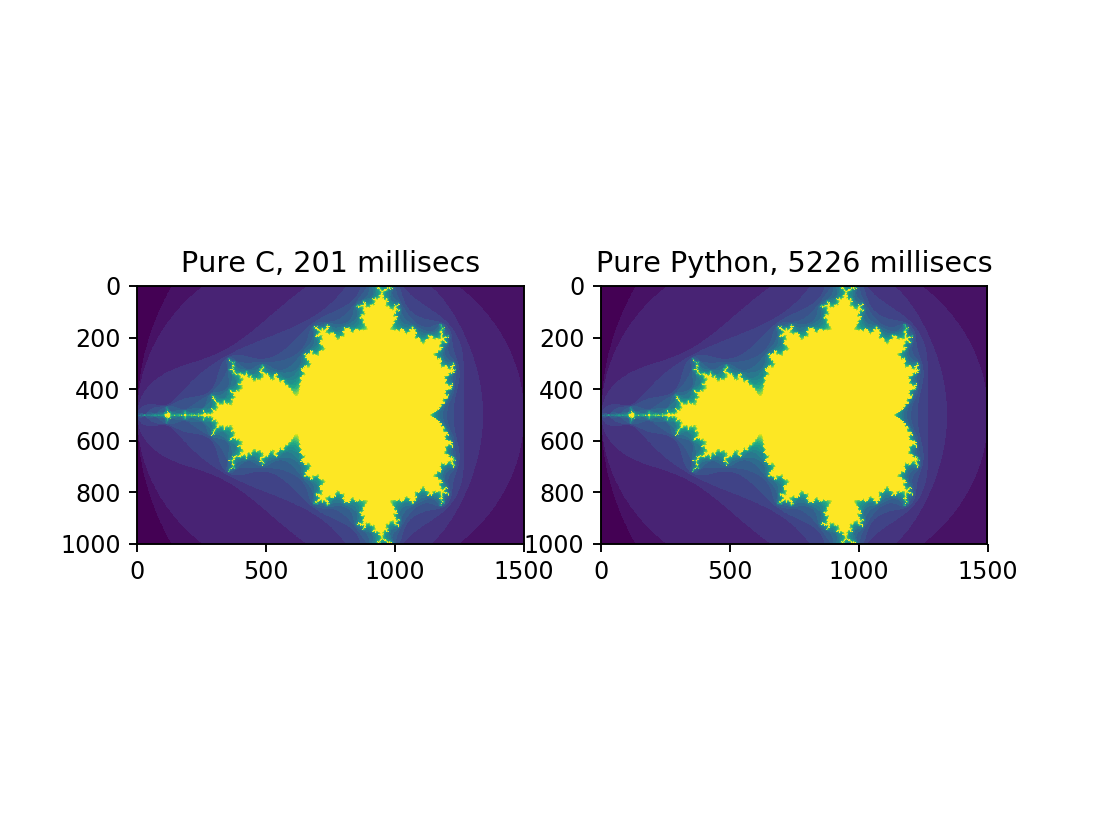

In [15]:
from matplotlib.pylab import imshow, show, figure, subplots
fig, ax = subplots(1,2)
with open('c.raw', 'rb') as fid:
    img = Image.frombytes(data=fid.read(), size=(1500,1000), mode="L")
ax[0].imshow(img); ax[0].set_title('Pure C, {:d} millisecs'.format(pure_c))
img = Image.open('python_numpy.png')
ax[1].imshow(img); ax[1].set_title('Pure Python, {:.0f} millisecs'.format(1000*pure_python));

Cool. We now have  a version in pure C that runs in about 200 ms. 

But hang on, we wanted this to be part of a whole pipeline, where we can use and reuse the functions ``mandel`` and ``create_fractal``. 

Note that we compiled ``libcreate_fractal.so`` as a shared object, so maybe we can call it from Python?

We have heard of three methods to interface C with Python: ctypes, cffi, cython. Let's try them out

In [16]:
#ctypes
# First all the declarations. Each function and struct must be redefined ...
import ctypes

class CtypesImg(ctypes.Structure):
    _fields_ = [('width', ctypes.c_int),
                ('height', ctypes.c_int),
                ('data', ctypes.POINTER(ctypes.c_uint8)), # HUH?
               ]

    def __init__(self, width, height):
        self.width = width
        self.height = height
        # Note this creates a class for each width*height value
        # but will keep the img.data alive in the interpreter
        self.data = (ctypes.c_uint8 * (width * height))() # !!!!!!

    def asmemoryview(self):
        # There must be a better way, but this code will not
        # be timed, so explicit trumps implicit
        ret = (ctypes.c_uint8 * (width * height))()
        for i in range(width*height):
            ret[i] = self.data[i]
        return memoryview(ret)

img = CtypesImg(width, height)

    
# Load the DLL
cdll = ctypes.cdll.LoadLibrary('./libcreate_fractal.so')

#Fish the function pointers from the DLL and define the interfaces
create_fractal_ctypes = cdll.create_fractal
create_fractal_ctypes.argtypes = [CtypesImg, ctypes.c_int]

mandel_ctypes = cdll.mandel
mandel_ctypes.argtypes = [ctypes.c_float, ctypes.c_float, ctypes.c_int, ctypes.POINTER(ctypes.c_uint8)]

### Ctypes use

Let's run this, twice. Once to call the c implementation of create_fractal, and again with
the python implementation of [create_fractal](#The-looping-function) which calls the c-mandel function 
1.5 million times

In [17]:
s = timer()
create_fractal_ctypes(img, 20)
e = timer()
ctypes_onecall = e - s
print('ctypes calling create_fractal required {:.2f} millisecs'.format(1000*ctypes_onecall))
im = Image.frombuffer("L", (width, height), img.asmemoryview(), 'raw', 'L', 0, 1)
im.save('ctypes_fractal.png')

value = (ctypes.c_uint8*1)()
s = timer()
create_fractal(img, 20, mandel_ctypes, value)
e = timer()
ctypes_createfractal = e - s
print('ctypes calling mandel required {:.2f} millisecs'.format(1000*ctypes_createfractal))
im = Image.frombuffer("L", (width, height), img.asmemoryview(), 'raw', 'L', 0, 1)
im.save('ctypes_mandel.png')

ctypes calling create_fractal required 203.95 millisecs
ctypes calling mandel required 2604.29 millisecs


<IPython.core.display.Javascript object>


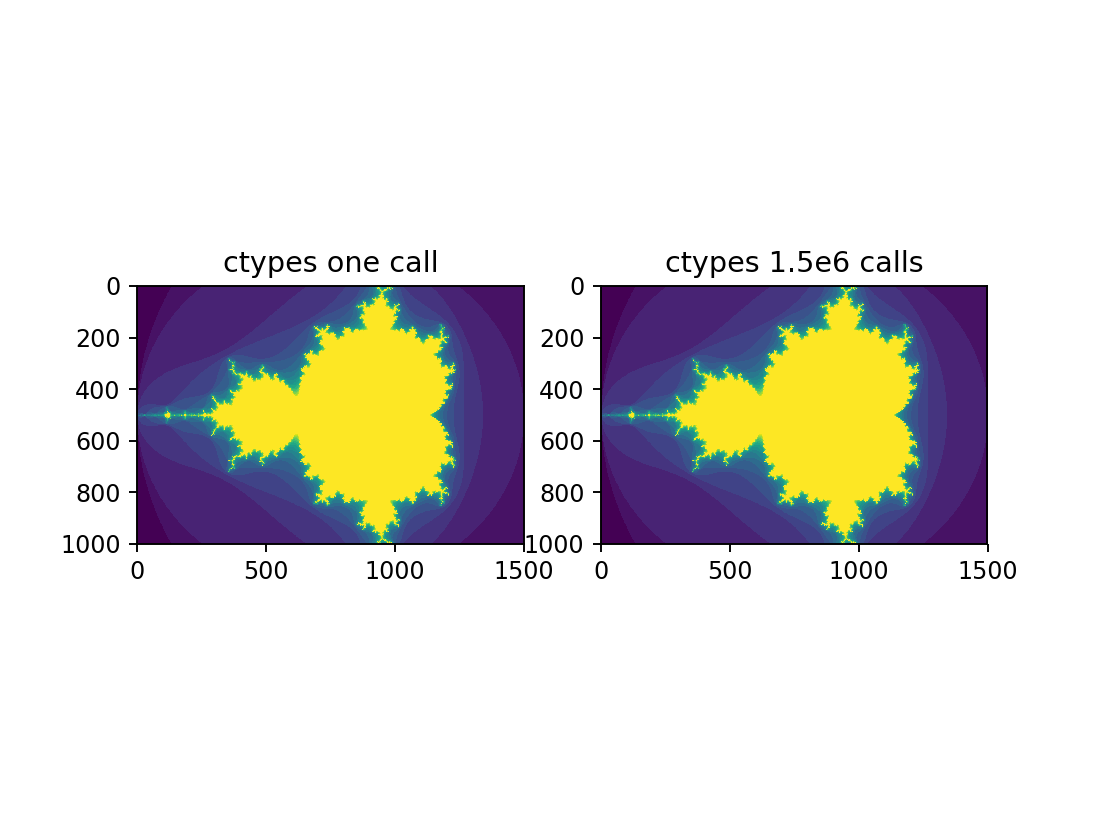

In [18]:
fig, ax = subplots(1,2)
ctypes1 = Image.open('ctypes_fractal.png')
ctypes2 = Image.open('ctypes_mandel.png')
ax[0].imshow(ctypes1); ax[0].set_title('ctypes one call')
ax[1].imshow(ctypes2); ax[1].set_title('ctypes 1.5e6 calls');

In [19]:
#cffi
import cffi
ffi = cffi.FFI()
# Two stages, cdef reads the headers, then dlopen finds the functions in the shared object

with open('create_fractal.h', 'rt') as fid:
    header = fid.read()
    # clean up all preprocessor macros before calling this
    print('Contents of create_fractal.h\n------------\n')
    ffi.cdef(header)
    print(header)

dll = ffi.dlopen('./libcreate_fractal.so')

Contents of create_fractal.h
------------

typedef struct _Img{
    int width;
    int height;
    unsigned char * data;
} cImg;



int create_fractal(cImg img, int iters);
int mandel(float real, float imag, int max_iters, unsigned char * val);




### CFFI use

Let's run this, twice. Once to call the c implementation of create_fractal, and again with
the python implementation of [create_fractal](#The-looping-function) which calls the c-mandel function 
1.5 million times

In [20]:
# Initializing an image looks just like C. Note two things:
# - ffi has state, that is the point of creating an ffi object
# - img is a "pointer", so we use img[0] to dereference it
img = ffi.new('cImg[1]')
img[0].width = width
img[0].height = height
img[0].data = ffi.new('unsigned char[%d]' % (width*height,)) # NO NO NO NO
# This is C - we must keep the pointer alive !!!
data1 = ffi.new('unsigned char[%d]' % (width*height,))
img[0].data = data1

In [21]:
s = timer()
dll.create_fractal(img[0], 20)
e = timer()
cffi_onecall = e - s
print('cffi calling create_fractal required {:.2f} millisecs'.format(1000 * cffi_onecall))
m = Image.frombuffer('L', (width, height), ffi.buffer(data1), 'raw', 'L', 0, 1)
im.save('cffi_fractal.png')

data2 = ffi.new('unsigned char[%d]' % (width*height,))
img[0].data = data2
value = ffi.new('unsigned char[1]')
s = timer()
create_fractal(img[0], 20, dll.mandel, value)
e = timer()
cffi_fractal = e - s
print('cffi calling mandel required {:.2f} millisecs'.format(1000*cffi_fractal))
im = Image.frombuffer('L', (width, height), ffi.buffer(data2), 'raw', 'L', 0, 1)
im.save('cffi_mandel.png')

cffi calling create_fractal required 199.04 millisecs
cffi calling mandel required 1058.79 millisecs


<IPython.core.display.Javascript object>


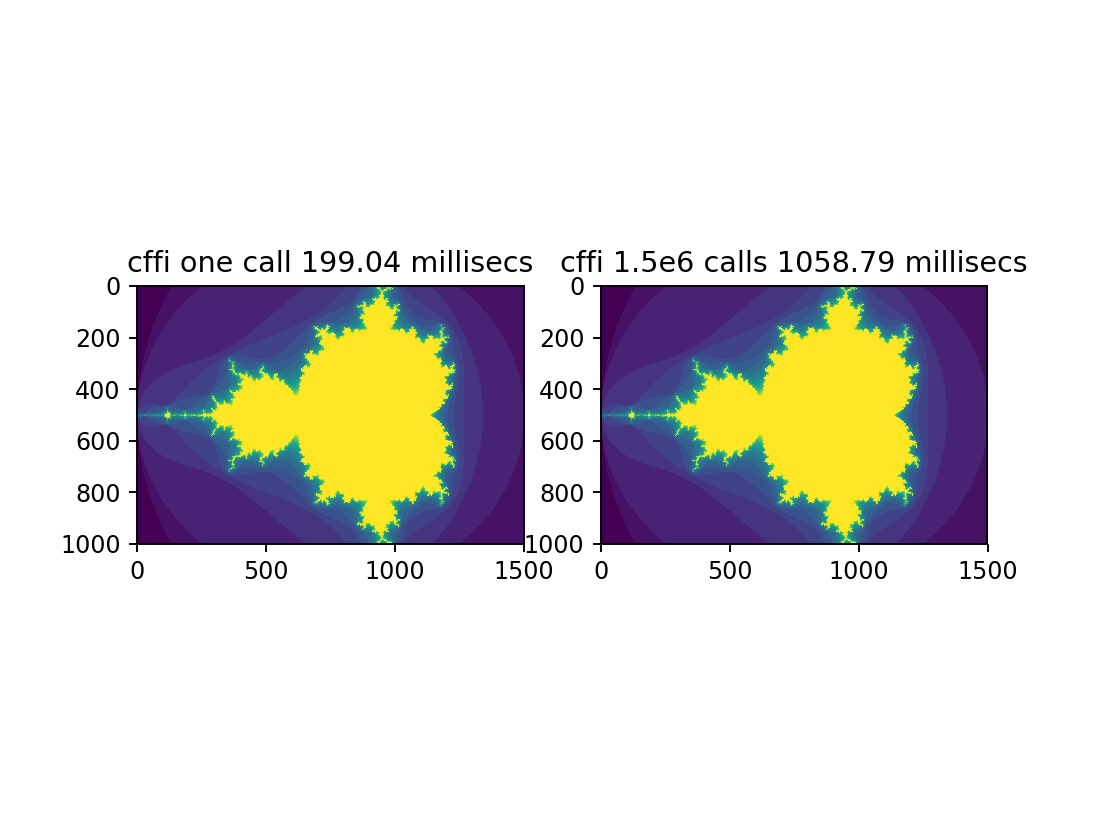

In [22]:
fig, ax = subplots(1,2)
ctypes1 = Image.open('cffi_fractal.png')
ctypes2 = Image.open('cffi_mandel.png')
ax[0].imshow(ctypes1); ax[0].set_title('cffi one call {:.2f} millisecs'.format(1000*cffi_onecall))
ax[1].imshow(ctypes2); ax[1].set_title('cffi 1.5e6 calls {:.2f} millisecs'.format(1000*cffi_fractal));

In [23]:
%load_ext Cython

Hang on, isn't cython used for compiling python to C? 

## FOUL!

Well, yes, but, in this case we already have c code from our contractor...
So really it's not Cython that is "ugly" but my use of it.

In [24]:
%%cython -a -I. -L. -l create_fractal --link-args=-Wl,-rpath=.

cdef extern from 'create_fractal.h':
    ctypedef struct cImg:
        int width
        int height
        unsigned char * data
    
    int create_fractal(cImg img, int iters);
    int mandel(float real, float imag, int max_iters, unsigned char * val);
    
def cython_create_fractal(pyimg, iters):
    cdef cImg cimg
    cdef int citers
    cdef unsigned char[::1] tmp = pyimg.data
    
    citers = iters
    cimg.width = pyimg.width
    cimg.height = pyimg.height
    cimg.data = &tmp[0]
    return create_fractal(cimg, citers)


cpdef int cython_mandel(float real, float imag, int max_iters, unsigned char[::1] val):
    return mandel(real, imag, max_iters, &val[0])

### Cython use

Let's run this, twice. Once to call the c implementation of create_fractal, and again with
the python implementation of [create_fractal](#The-looping-function) which calls the c-mandel function 
1.5 million times

In [25]:
# use it, remember we have "image" from the pure python version 

s = timer()
cython_create_fractal(image, 20)
e = timer()
cython_onecall = e - s
print('cython onecall required {:.2f} millisecs'.format(1000*cython_onecall))
im = Image.frombuffer("L", (width, height), image.data, "raw", "L", 0, 1)
im.save('cython_fractal.png')

value = bytearray(1)
s = timer()
create_fractal(image, 20, cython_mandel, value)
e = timer()
cython_fractal = e - s
print('cython many calls required {:.2f} millisecs'.format(1000*cython_fractal))
im = Image.frombuffer("L", (width, height), image.data, "raw", "L", 0, 1)
im.save('cython_mandel.png')

cython onecall required 197.98 millisecs
cython many calls required 952.33 millisecs


<IPython.core.display.Javascript object>


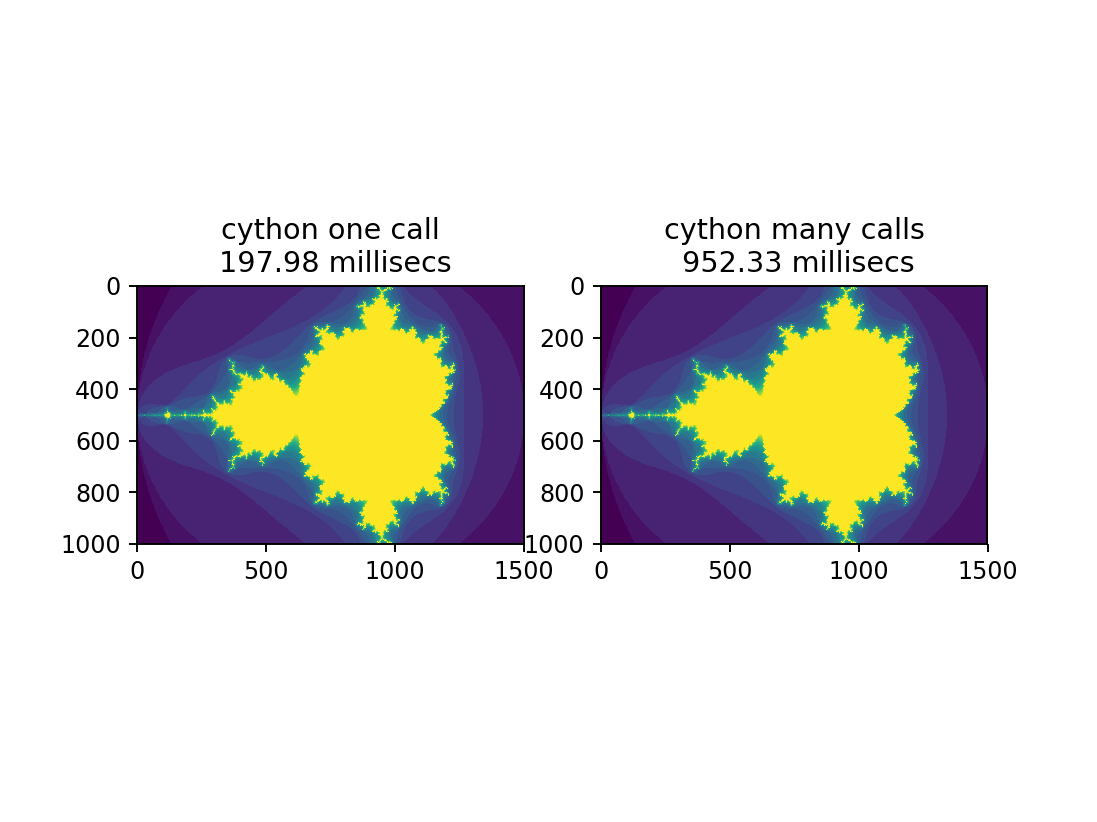

In [26]:
fig, ax = subplots(1,2)
ctypes1 = Image.open('cython_fractal.png')
ctypes2 = Image.open('cython_mandel.png')
ax[0].imshow(ctypes1); ax[0].set_title('cython one call\n {:.2f} millisecs'.format(1000*cython_onecall))
ax[1].imshow(ctypes2); ax[1].set_title('cython many calls\n {:.2f} millisecs'.format(1000*cython_fractal))
fig.show()

In [27]:
# Now let's try and work out who is the good, who the bad, and who the ugly
import pprint
pprint.pprint([['      ', 'CreateFractal in Python', 'CreateFractal in C'],
              ['Python', '{:13.2f} millisecs'.format(1000*pure_python), '{:18s}'.format('')],
              ['C     ', '{:23s}'.format(''), '{:8.2f} millisecs'.format(pure_c)],
              ['ctypes', '{:13.2f} millisecs'.format(1000*ctypes_createfractal), '{:8.2f} millisecs'.format(1000*ctypes_onecall)],
              ['cffi  ', '{:13.2f} millisecs'.format(1000*cffi_fractal), '{:8.2f} millisecs'.format(1000*cffi_onecall)],
              ['cython', '{:13.2f} millisecs'.format(1000*cython_fractal), '{:8.2f} millisecs'.format(1000*cython_onecall)],
             ])

[['      ', 'CreateFractal in Python', 'CreateFractal in C'],
 ['Python', '      5225.69 millisecs', '                  '],
 ['C     ', '                       ', '  201.00 millisecs'],
 ['ctypes', '      2604.29 millisecs', '  203.95 millisecs'],
 ['cffi  ', '      1058.79 millisecs', '  199.04 millisecs'],
 ['cython', '       952.33 millisecs', '  197.98 millisecs']]


Things to think about, besides speed:

* Maintainability
  - What happens when the C code changes?
* Compiler dependency
  - ctypes needs none, Cython requires one, CFFI can go either way
* Suseptability to bugs (object lifetimes, signature mismatches)
  - All use a minilanguage for interfacing, only CFFI's is standard C
  - Cython will handle most transformations automatically
  - CFFI can be tricky for C-level pointers
* Speed and productivity
  - Cython is heavily optimized, tightly integrated to the C-API
  - If the headers are pure C, CFFI should be simple
  - Projects exist to generate wrappers for all three
* Which technology is actively maintained (ctypes went into the stdlib to die?)

And now the pop-quiz. If we run the pure python version in PyPy what time will we get?:

* Around a 2X speed up
* About like Cython or CFFI calling mandel 1.5e6 times
* About like C compiled -O3

In [28]:
%%script pypy
from __future__ import print_function, division
import sys
print(sys.executable)
print(sys.version)
from timeit import default_timer as timer

from PIL import Image


class Img(object):
    def __init__(self, width, height):
        self.width = width
        self.height = height
        self.data = bytearray(width*height)

def create_fractal(image, iters, func, oneval):
    ''' Call a function for each pixel in the image, where
        -2 < real < 1 over the columns and
        -1 < imag < 1 over the rows
    '''
    pixel_size_x = 3.0 / image.width
    pixel_size_y = 2.0 / image.height
    for y in range(image.height):
        imag = y * pixel_size_y - 1
        yy = y * image.width
        for x in range(image.width):
            real = x * pixel_size_x - 2
            func(real, imag, iters, oneval)
            image.data[yy + x] = oneval[0]

def mandel(x, y, max_iters, value):
    """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
    """
    i = 0
    c = complex(x,y)
    z = 0.0j
    for i in range(max_iters):
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= 4:
            value[0] = i
            return 0
    value[0] = max_iters
    return max_iters

# Pure python
width = 1500
height = 1000
image = Img(width, height)
s = timer()
oneval = bytearray(1)
create_fractal(image, 20, mandel, oneval) # < --- HERE IS THE CALL
e = timer()
pure_pypy = e - s
print('pure pypy required {:.2f} millisecs'.format(1000*pure_pypy))
im = Image.frombuffer('L', (1500, 1000), image.data, 'raw', 'L', 0, 1)
im.save('pypyy.png')

/usr/local/bin/pypy
2.7.13 (5e7bef99e9f5, May 31 2017, 22:00:12)
[PyPy 5.9.0-alpha0 with GCC 6.2.0 20160901]
pure pypy required 158.50 millisecs


<IPython.core.display.Javascript object>


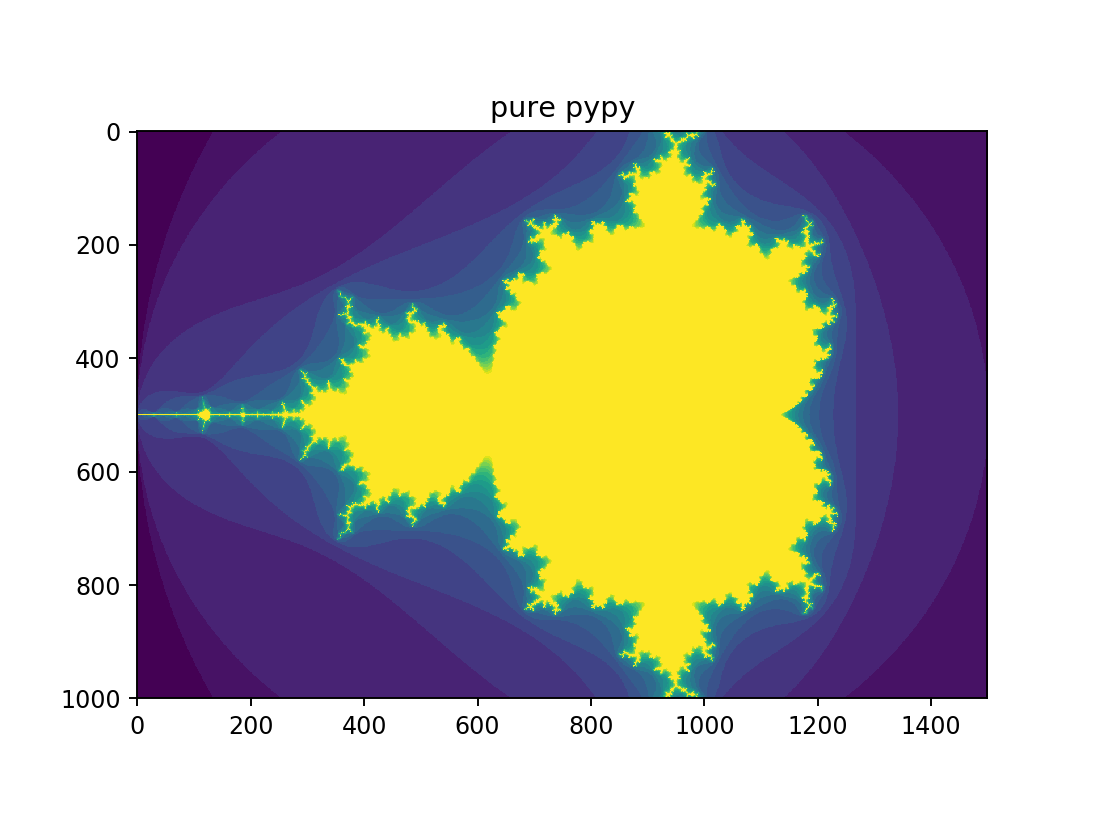

In [29]:
fig, ax = subplots(1)
ctypes1 = Image.open('pypyy.png')
ax.imshow(ctypes1); ax.set_title('pure pypy');